In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, DMatrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
# from imblearn.over_sampling import SMOTENC
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, log_loss
from collections import Counter
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score

from typing import List, Dict
from sklearn.metrics import log_loss, accuracy_score, balanced_accuracy_score
import numpy as np 
import matplotlib.pyplot as plt

from collections import OrderedDict
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns
from sklearn.metrics import confusion_matrix

# File path
input_file = r"~/Downloads/CHI-JA-WLOOP-ATT-HTTP-MERGED.csv"

# Read the CSV file without specifying columns to inspect the column names
df = pd.read_csv(input_file)

# List of columns you want to keep in the output CSV
columns_to_keep = [
    "5G KPI PCell RF Serving PCI", 
    "5G KPI PCell RF Frequency [MHz]", 
    "5G KPI PCell RF Subcarrier Spacing",
#     "5G KPI PCell RF Duplex Mode",
    "5G KPI PCell RF Tx Beam ID 0",
    "5G KPI PCell RF Rx Beam ID 0",
    "5G KPI PCell RF Rx Beam ID 1",
#     "5G KPI PCell RF Serving SSB Idx", #REMOVED
    "5G KPI PCell RF Serving SS-RSRP [dBm]", 
    "5G KPI PCell RF Serving SS-RSRQ [dB]",
    "5G KPI PCell RF Serving SS-SINR [dB]",
    "5G KPI PCell RF Pathloss [dB]",
    "5G KPI PCell RF RI",
    "5G KPI PCell RF RI1 Rate [%]",
    "5G KPI PCell RF RI2 Rate [%]",
    "5G KPI PCell RF CQI",
    "5G KPI PCell RF PMI i(1;1)",
    "5G KPI PCell RF PMI i(1;2)",
    "5G KPI PCell RF PMI i(1;3)",
    "5G KPI PCell RF PMI i(2)",
    "5G KPI PCell RF LI",
    "5G KPI PCell RF TA",
    "5G KPI PCell RF PRACH Power [dBm]",
    "5G KPI PCell RF PUSCH Power [dBm]", 
    "5G KPI PCell RF PUCCH Power [dBm]",
    "5G KPI PCell RF SRS Power [dBm]",
    "5G KPI PCell RF ENDC Tx Power [dBm]",
    "5G KPI PCell RF Neighbor Top1 PCI",
    "5G KPI PCell RF Neighbor Top1 SS-RSRP [dBm]",
    "5G KPI PCell RF Neighbor Top1 SS-RSRQ [dB]",
    "5G KPI PCell RF Neighbor Top2 PCI",
    "5G KPI PCell RF Neighbor Top2 SS-RSRP [dBm]",
    "5G KPI PCell RF Neighbor Top2 SS-RSRQ [dB]",
    "5G KPI PCell RF Neighbor Top3 PCI",
    "5G KPI PCell RF Neighbor Top3 SS-RSRP [dBm]",
    "5G KPI PCell RF Neighbor Top3 SS-RSRQ [dB]",
    "5G KPI PCell Layer1 DL BLER [%]",
    "5G KPI PCell Layer1 UL BLER [%]",
    "5G KPI PCell Layer1 DL RB Num (Avg)",
    "5G KPI PCell Layer1 UL RB Num (Avg)",
    "5G KPI PCell Layer1 PDSCH Throughput [Mbps]",
    "5G KPI PCell Layer1 PUSCH Throughput [Mbps]"
]

# Read the input CSV file
df = pd.read_csv(input_file, low_memory=False)

# Check the initial shape of the DataFrame
print("Initial shape:", df.shape)

# Filter columns
df = df[columns_to_keep]

df['5G KPI PCell RF Subcarrier Spacing'] = df['5G KPI PCell RF Subcarrier Spacing'].replace({'120kHz': 0.12, '15kHz': 0.015})

# Clean column names
cleaned_columns = [col.replace('[', '').replace(']', '').replace('%', 'Percent').replace(' ', '').replace('(', '').replace(')', '') for col in df.columns]
df.columns = cleaned_columns

# Dictionary to map the original to cleaned column names for clarity
column_mapping = dict(zip(columns_to_keep, cleaned_columns))

# Keep only records up to and including line 26017
df = df.iloc[:26018]

def average_consecutive_nan(column):
  nan_lengths = []
  current_length = 0
  for value in column.isnull():
    if value:
      current_length += 1
    else:
      if current_length > 0:
        nan_lengths.append(current_length)
      current_length = 0
  if current_length > 0:
    nan_lengths.append(current_length)
  return np.mean(nan_lengths) if nan_lengths else 0

for col in [column_mapping["5G KPI PCell RF Serving PCI"], 
            column_mapping["5G KPI PCell RF Frequency [MHz]"],
            column_mapping["5G KPI PCell RF Neighbor Top1 PCI"],
            column_mapping["5G KPI PCell RF Neighbor Top2 PCI"],
            column_mapping["5G KPI PCell RF PMI i(1;1)"],
            column_mapping["5G KPI PCell RF PMI i(1;2)"],
            column_mapping["5G KPI PCell RF PMI i(1;3)"]]:
                df[col] = df[col].fillna(method='ffill', limit=int(average_consecutive_nan(df[col]))).fillna(df[col].mode().iloc[0])
for col in [
           column_mapping["5G KPI PCell RF Subcarrier Spacing"],
           column_mapping["5G KPI PCell RF Rx Beam ID 0"],
           column_mapping["5G KPI PCell RF Rx Beam ID 1"],
#            column_mapping["5G KPI PCell RF Serving SSB Idx"], #REMOVED
           column_mapping["5G KPI PCell RF RI"],
#            column_mapping["5G KPI PCell RF PMI i(1;1)"],
           column_mapping["5G KPI PCell RF PMI i(2)"],
           column_mapping["5G KPI PCell RF LI"],
           column_mapping["5G KPI PCell RF TA"],
#            column_mapping["5G KPI PCell RF Neighbor Top1 PCI"],
#            column_mapping["5G KPI PCell RF Neighbor Top2 PCI"],
           column_mapping["5G KPI PCell RF Neighbor Top3 PCI"]]:
                if df[col].mode().empty:
                    df[col] = df[col].fillna(df[col].median())
                else:
                    df[col] = df[col].fillna(df[col].mode().iloc[0])

columns_to_remove = [
    column_mapping["5G KPI PCell RF Rx Beam ID 0"],
    column_mapping["5G KPI PCell RF PRACH Power [dBm]"],#<0.05
    column_mapping["5G KPI PCell RF Rx Beam ID 1"],
    column_mapping["5G KPI PCell RF ENDC Tx Power [dBm]"],
    column_mapping["5G KPI PCell RF SRS Power [dBm]"],
    column_mapping["5G KPI PCell RF Subcarrier Spacing"],
#     column_mapping["5G KPI PCell RF Duplex Mode"],
    column_mapping["5G KPI PCell RF RI"],
    column_mapping["5G KPI PCell RF RI1 Rate [%]"],
    column_mapping["5G KPI PCell RF RI2 Rate [%]"],
    column_mapping["5G KPI PCell RF PMI i(1;1)"],
    column_mapping["5G KPI PCell RF PMI i(2)"],
    column_mapping["5G KPI PCell RF PMI i(1;2)"],
    column_mapping["5G KPI PCell RF PMI i(1;3)"],
    column_mapping["5G KPI PCell RF LI"], #LI always 1 here so its just noise
    column_mapping["5G KPI PCell RF TA"],
    column_mapping["5G KPI PCell RF Neighbor Top3 PCI"],#<0.05
    column_mapping["5G KPI PCell RF Neighbor Top3 SS-RSRP [dBm]"],#<0.05
    column_mapping["5G KPI PCell RF Neighbor Top3 SS-RSRQ [dB]"]#<0.05
#     column_mapping["5G KPI PCell RF SRS Power [dBm]"]
]
# Ensure all columns to remove are mapped correctly
# print("Columns to remove (mapped):", columns_to_remove)

# Drop the columns
df = df.drop(columns=columns_to_remove)

# Verify the columns after dropping
# print("Remaining columns after dropping:")
# print(df.columns)          
# Impute remaining NaNs with column mean
for col in df.columns:
    if col not in [
           column_mapping["5G KPI PCell RF Tx Beam ID 0"],
           column_mapping["5G KPI PCell RF Serving PCI"],
           column_mapping["5G KPI PCell RF Frequency [MHz]"],
           column_mapping["5G KPI PCell RF Neighbor Top1 PCI"],
           column_mapping["5G KPI PCell RF Neighbor Top2 PCI"]
                  ]:
                df[col] = df[col].fillna(df[col].mean())
# df[column_mapping["5G KPI PCell RF PRACH Power [dBm]"]] = df[column_mapping["5G KPI PCell RF PRACH Power [dBm]"]].fillna(df[column_mapping["5G KPI PCell RF PRACH Power [dBm]"]].mean())

# Remove columns from DataFrame
df = df.dropna(subset=[column_mapping["5G KPI PCell RF Tx Beam ID 0"]]) # Drop AFTER CLEANING!
# print(Counter(df[column_mapping["5G KPI PCell RF Tx Beam ID 0"]]))

# print(df.columns)

categorical_columns=[
#         column_mapping["5G KPI PCell RF Tx Beam ID 0"], #target
        column_mapping["5G KPI PCell RF Serving PCI"],
        column_mapping["5G KPI PCell RF Neighbor Top1 PCI"],
        column_mapping["5G KPI PCell RF Neighbor Top2 PCI"]]
numerical_columns = [col for col in df.columns if col not in categorical_columns and col != column_mapping["5G KPI PCell RF Tx Beam ID 0"]]
# print(numerical_columns)

for col in categorical_columns:
    df[col] = df[col].astype('category')
for col in df.columns:
    if col not in categorical_columns:
        df[col] = df[col].astype('float')
df[column_mapping["5G KPI PCell RF Tx Beam ID 0"]].astype('category') #target
df = df.drop(columns=column_mapping["5G KPI PCell RF Neighbor Top1 PCI"])
df = df.drop(columns=column_mapping["5G KPI PCell RF Neighbor Top2 PCI"])
df = df.drop(columns=column_mapping["5G KPI PCell RF Serving PCI"])
# print(df.columns)
# Split the data into features and target
X = df.drop(column_mapping["5G KPI PCell RF Tx Beam ID 0"], axis=1)
y = df[column_mapping["5G KPI PCell RF Tx Beam ID 0"]]
print("before dropping bad classes: ", Counter(df[column_mapping["5G KPI PCell RF Tx Beam ID 0"]]))
# REMOVE SMALL CLASSES
mask = ~y.isin([13.0, 38.0, 26.0, 15.0, 37.0, 24.0, 39.0, 23.0, 30.0, 43.0, 21.0, 33.0, 42.0, 12.0, 20.0, 22.0,
         31.0, 8.0, 14.0, 63.0, 45.0, 47.0, 35.0, 52.0, 53.0, 46.0, 6.0, 59.0, 58.0,
         56.0, 54.0, 57.0, 55.0, 44.0, 61.0, 2.0, 60.0, 11.0, 9.0, 40.0, 36.0, 7.0, 28.0, 25.0, 41.0
        # ])
         , 3.0, 4.0, 5.0, 32.0, 10.0, 29.0])
        #  , 32.0, 10.0, 29.0])
X= X[mask]
y= y[mask]
print("after dropping bad classes: ", Counter(y))

/var/folders/t3/736m4c7914ggm6c17vd2z3nr0000gn/T/ipykernel_23603/3395586545.py:36: DtypeWarning: Columns (10,81,82,84,85,89,97,140,141,143,144,151,182,183,185,186,193,202,203,205,206,213,222,223,225,226,233,242,243,245,246,253,262,263,265,266,273,282,283,285,286,293) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)


Initial shape: (26016, 306)
before dropping bad classes:  Counter({34.0: 543, 0.0: 409, 62.0: 307, 27.0: 307, 1.0: 299, 29.0: 206, 5.0: 163, 3.0: 158, 4.0: 139, 32.0: 122, 10.0: 103, 11.0: 94, 9.0: 86, 40.0: 73, 36.0: 64, 7.0: 62, 28.0: 57, 25.0: 55, 41.0: 52, 13.0: 49, 38.0: 49, 26.0: 40, 15.0: 39, 37.0: 39, 24.0: 37, 39.0: 36, 23.0: 36, 30.0: 35, 43.0: 28, 21.0: 28, 33.0: 22, 42.0: 21, 12.0: 19, 20.0: 19, 22.0: 18, 31.0: 18, 8.0: 15, 14.0: 15, 63.0: 13, 45.0: 11, 47.0: 11, 35.0: 11, 52.0: 9, 53.0: 9, 46.0: 8, 6.0: 7, 59.0: 7, 58.0: 6, 56.0: 6, 54.0: 6, 57.0: 6, 55.0: 6, 44.0: 5, 61.0: 3, 2.0: 3, 60.0: 2})
after dropping bad classes:  Counter({34.0: 543, 0.0: 409, 62.0: 307, 27.0: 307, 1.0: 299})


/var/folders/t3/736m4c7914ggm6c17vd2z3nr0000gn/T/ipykernel_23603/3395586545.py:93: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['5G KPI PCell RF Subcarrier Spacing'] = df['5G KPI PCell RF Subcarrier Spacing'].replace({'120kHz': 0.12, '15kHz': 0.015})
/var/folders/t3/736m4c7914ggm6c17vd2z3nr0000gn/T/ipykernel_23603/3395586545.py:126: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill', limit=int(average_consecutive_nan(df[col]))).fillna(df[col].mode().iloc[0])


In [2]:
# Cell 1: Imports and Data Preparation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

# Assume X and y are already defined

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = dict(zip(np.unique(y_train), class_weights))

# Assign sample weights
sample_weights = np.array([weight_dict[label] for label in y_train])

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, balanced_accuracy_score, accuracy_score, roc_auc_score, average_precision_score, confusion_matrix
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.read_pickle('att_rand_forest_rand_search_results.pkl')

# # Cell 1: Custom Scorer and Random Search
# def custom_scorer(estimator, X, y):
#     y_pred = estimator.predict(X)
#     return balanced_accuracy_score(y, y_pred)

# class CustomRandomizedSearchCV(RandomizedSearchCV):
#     def fit(self, X, y, **fit_params):
#         super().fit(X, y, **fit_params)
#         self.train_scores_ = []
#         self.test_scores_ = []
#         for params, cv_results in zip(self.cv_results_['params'], self.cv_results_['split0_test_score']):
#             estimator = self.estimator.set_params(**params)
#             estimator.fit(X, y, **fit_params)
#             self.train_scores_.append(custom_scorer(estimator, X, y))
#             self.test_scores_.append(cv_results)
#         return self

# # Define the parameter space for Random Forest
# param_dist = {
#     'n_estimators': randint(100, 500),
#     'max_depth': randint(3, 20),
#     'min_samples_split': randint(2, 20),
#     'min_samples_leaf': randint(1, 10),
#     'max_features': uniform(0.1, 0.9),
#     'bootstrap': [True, False]
# }

# # Create the Random Forest classifier
# rf_model = RandomForestClassifier(
#     random_state=42,
#     n_jobs=-1  # Use all available cores
# )

# # Set up CustomRandomizedSearchCV
# random_search = CustomRandomizedSearchCV(
#     rf_model,
#     param_distributions=param_dist,
#     n_iter=100,
#     scoring=make_scorer(balanced_accuracy_score),
#     n_jobs=-1,
#     cv=3,
#     verbose=1,
#     random_state=42
# )

# # Perform random search
# random_search.fit(X_train, y_train, sample_weight=sample_weights)

# # Create a DataFrame with results
# results_df = pd.DataFrame({
#     'params': random_search.cv_results_['params'],
#     'train_score': random_search.train_scores_,
#     'test_score': random_search.test_scores_
# })

# # Calculate the difference between train and test scores
# results_df['score_difference'] = results_df['train_score'] - results_df['test_score']


In [4]:
# Sort by the smallest difference
results_df = results_df.sort_values('score_difference')

# Saving in csv (human readable) and pickle (if you need to open it in code) format
results_df.to_pickle('att_rand_forest_rand_search_results.pkl')
results_df.to_csv('att_rand_forest_rand_search_results.csv', index=False)

# Display the top 10 models with the smallest difference
print("Top 10 models with smallest difference between train and test balanced accuracy:")
print(results_df[['train_score', 'test_score', 'score_difference']].head(40))

Top 10 models with smallest difference between train and test balanced accuracy:
    train_score  test_score  score_difference
40     0.612890    0.613199         -0.000310
45     0.613290    0.613078          0.000212
51     0.618009    0.615836          0.002173
72     0.621092    0.610639          0.010453
47     0.651991    0.635958          0.016033
7      0.653922    0.637018          0.016904
3      0.631053    0.612201          0.018852
14     0.636270    0.617079          0.019192
53     0.660446    0.630020          0.030426
73     0.668570    0.636465          0.032106
15     0.669031    0.636465          0.032566
5      0.671870    0.636465          0.035405
41     0.689965    0.652409          0.037556
8      0.695344    0.657470          0.037874
58     0.644936    0.605441          0.039495
9      0.644960    0.605441          0.039519
88     0.673068    0.632733          0.040335
55     0.702721    0.662348          0.040373
52     0.676576    0.634026          0.042550

In [5]:
# Creating a copy dataframe sorted by highest test score to see which model to choose manually
results_df_by_test_score = results_df.copy()
results_df_by_test_score = results_df_by_test_score.sort_values('test_score', ascending=False)
# print(results_df_by_test_score[['train_score', 'test_score', 'score_difference']].head(10))

# Manually selecting best model
print(results_df.iloc[19][['train_score', 'test_score', 'score_difference']])
best_params = results_df.iloc[19]['params']
# best_model = rf_model.set_params(**best_params)

print("\nBest model parameters:")
print(best_params)

train_score         0.721634
test_score          0.677729
score_difference    0.043906
Name: 80, dtype: object

Best model parameters:
{'bootstrap': True, 'max_depth': 5, 'max_features': np.float64(0.19281148195233935), 'min_samples_leaf': 1, 'min_samples_split': 18, 'n_estimators': 161}


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, balanced_accuracy_score, accuracy_score, roc_auc_score, average_precision_score, confusion_matrix
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns

# Cell 2: Using best model params to train and evaluate the model
# Train the final model
final_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train, sample_weight=sample_weights)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred_proba):
    y_pred = np.argmax(y_pred_proba, axis=1)
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'auroc': roc_auc_score(y_true, y_pred_proba, multi_class='ovr'),
        'auprc': average_precision_score(y_true, y_pred_proba, average='weighted')
    }

# Make predictions on the training and test sets
y_train_pred_proba = final_model.predict_proba(X_train)
y_test_pred_proba = final_model.predict_proba(X_test)

# Calculate final training and test metrics
train_metrics = calculate_metrics(y_train, y_train_pred_proba)
test_metrics = calculate_metrics(y_test, y_test_pred_proba)

print("\nFinal Training Metrics:")
for metric, value in train_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

print("\nFinal Test Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")


Final Training Metrics:
Accuracy: 0.6910
Balanced_accuracy: 0.7216
Auroc: 0.9350
Auprc: 0.8173

Final Test Metrics:
Accuracy: 0.6247
Balanced_accuracy: 0.6442
Auroc: 0.9028
Auprc: 0.7450


In [12]:
# Perform bootstrapping
def bootstrap_metrics(model, X, y, n_iterations=100):
    results = []
    for _ in range(n_iterations):
        # Sample with replacement
        bootstrap_indices = np.random.choice(len(X), size=len(X), replace=True)
        X_bootstrap = X.iloc[bootstrap_indices]
        y_bootstrap = y[bootstrap_indices]
        y_pred_proba = model.predict_proba(X_bootstrap)
        results.append(calculate_metrics(y_bootstrap, y_pred_proba))
    return pd.DataFrame(results)
    
bootstrap_results = bootstrap_metrics(final_model, X_test, y_test)

print("\nOpY Random Forest - Bootstrapped Test Metrics (Mean ± Std):")
for metric in bootstrap_results.columns:
    mean = bootstrap_results[metric].mean()
    std = bootstrap_results[metric].std()
    print(f"{metric.capitalize()}: {mean:.4f} (± {std:.4f})")


OpY Random Forest - Bootstrapped Test Metrics (Mean ± Std):
Accuracy: 0.6236 (± 0.0230)
Balanced_accuracy: 0.6451 (± 0.0227)
Auroc: 0.9020 (± 0.0095)
Auprc: 0.7481 (± 0.0224)



Top Feature Importances:
                                feature  importance
15           5GKPIPCellLayer1ULRBNumAvg    0.159998
0              5GKPIPCellRFFrequencyMHz    0.157466
8    5GKPIPCellRFNeighborTop1SS-RSRPdBm    0.136244
7             5GKPIPCellRFPUCCHPowerdBm    0.111051
9     5GKPIPCellRFNeighborTop1SS-RSRQdB    0.088203
14           5GKPIPCellLayer1DLRBNumAvg    0.063217
4                5GKPIPCellRFPathlossdB    0.055629
6             5GKPIPCellRFPUSCHPowerdBm    0.046377
1         5GKPIPCellRFServingSS-RSRPdBm    0.039088
17  5GKPIPCellLayer1PUSCHThroughputMbps    0.034311
10   5GKPIPCellRFNeighborTop2SS-RSRPdBm    0.028858
11    5GKPIPCellRFNeighborTop2SS-RSRQdB    0.023464
3          5GKPIPCellRFServingSS-SINRdB    0.018324
2          5GKPIPCellRFServingSS-RSRQdB    0.012980
16  5GKPIPCellLayer1PDSCHThroughputMbps    0.010669
5                       5GKPIPCellRFCQI    0.006609
12        5GKPIPCellLayer1DLBLERPercent    0.004365
13        5GKPIPCellLayer1ULBLERPercen

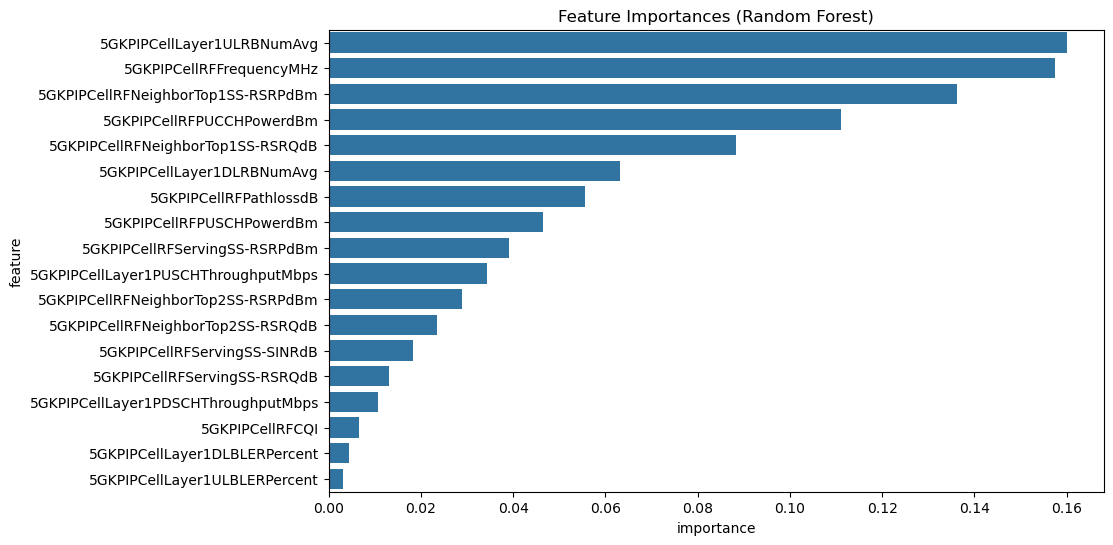

In [8]:
# Feature importance
importance_scores = final_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance_scores})
importance_df = importance_df.sort_values('importance', ascending=False)

print("\nTop Feature Importances:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(20))
plt.title('Feature Importances (Random Forest)')
plt.show()

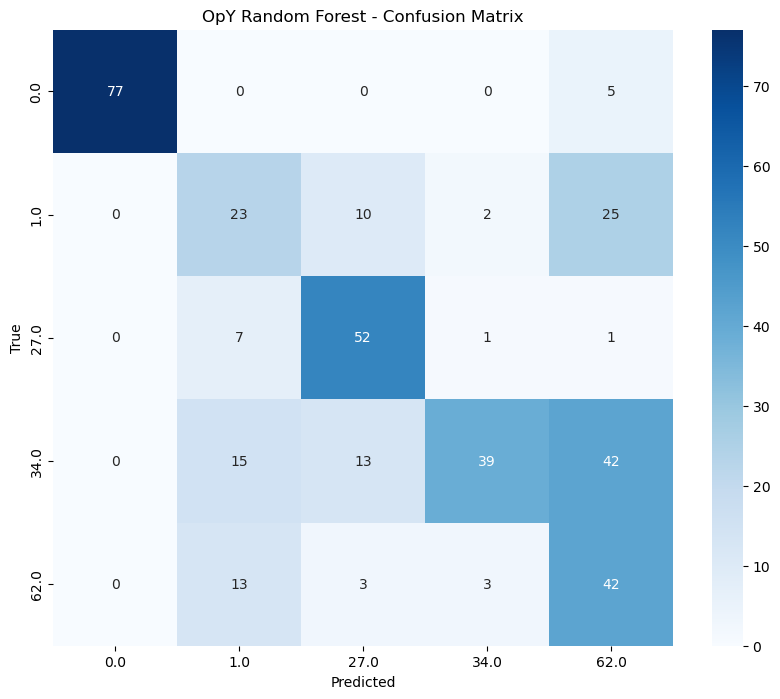

In [9]:
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('OpY Random Forest - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

y_test_pred = np.argmax(y_test_pred_proba, axis=1)
plot_confusion_matrix(y_test, y_test_pred, classes=le.classes_)

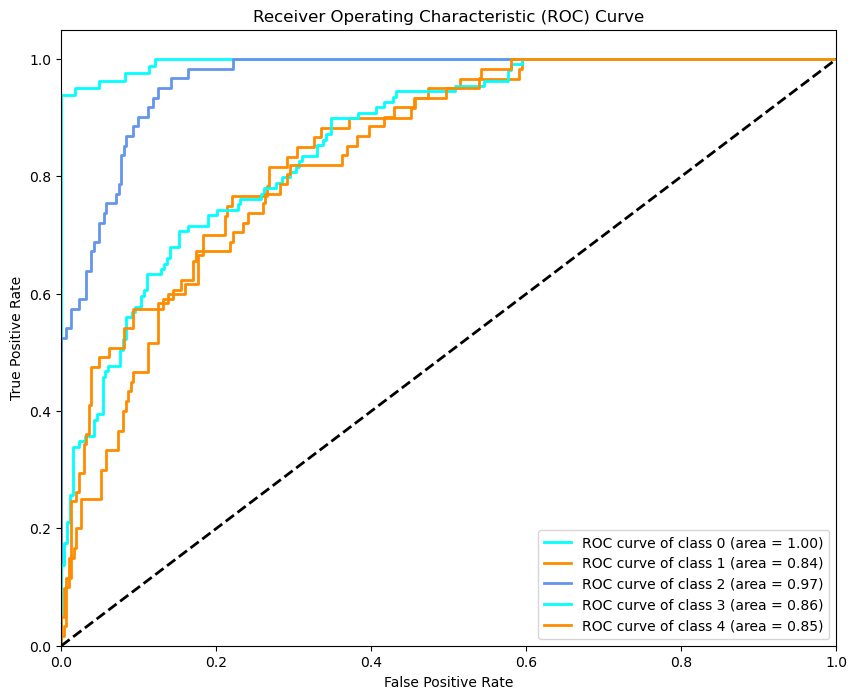

In [10]:
# ROC Curve plot
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_test))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

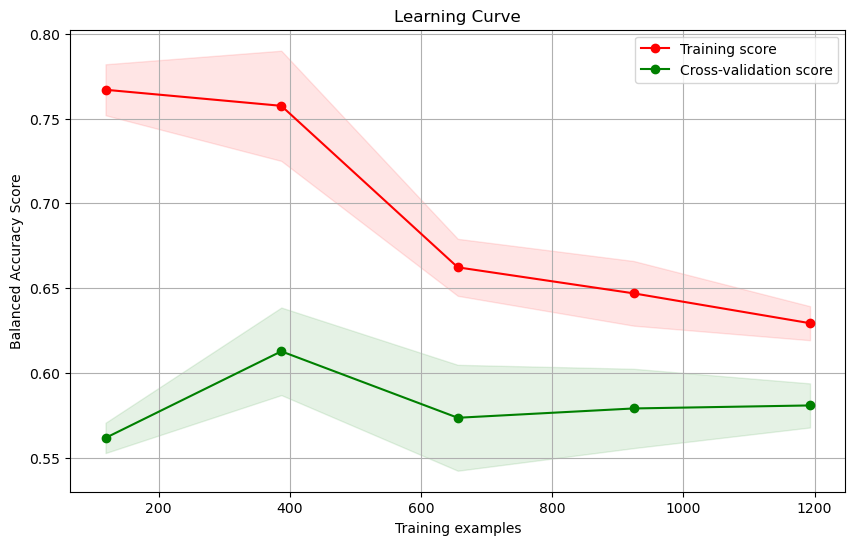

In [11]:
from sklearn.model_selection import learning_curve

# Plot learning curves
def plot_learning_curve(estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='balanced_accuracy'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Balanced Accuracy Score")
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot the learning curve
plot_learning_curve(final_model, X_train, y_train)